In [23]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.1 MB 2.0 MB/s eta 0:00:20
   --- ------------------------------------ 3.2/38.1 MB 41.0 MB/s eta 0:00:01
   -------- ------------------------------- 8.4/38.1 MB 67.5 MB/s eta 0:00:01
   -------------- ------------------------- 13.5/38.1 MB 108.8 MB/s eta 0:00:01
   ------------------- -------------------- 18.6/38.1 MB 108.8 MB/s eta 0:00:01
   ---------------------- ----------------- 21.2/38.1 MB 93.9 MB/s eta 0:00:01
   ------------------------ --------------- 23.1/38.1 MB 81.8 MB/s eta 0:00:01
   ------------------------- -------------- 24.2/38.1 MB 59.5 MB/s eta 0:00:01
   ------------------------------ --------- 28.8/38.1 MB 59.5 MB/s eta 0:00:01


In [105]:
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision import datasets
#from google.colab import drive
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
import glob
import json
import random
from IPython.display import clear_output
#!drive unmount
#!drive mount '/content/drive', force_remount=True
#drive.mount('/content/drive')

In [2]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/data.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('/content/') # 압축을 해제할 '/위치경로/'


In [4]:

# 이미지 zip 파일 경로
validation_folder_path = 'data/Validation'
training_folder_path = 'data/Training'

training_image_folder_path = os.listdir(os.path.join(training_folder_path,'data'))
training_label_folder_path = os.listdir(os.path.join(training_folder_path,'label'))
#ex) Ts..1960m Ts..1970...
validation_image_folder_path = os.listdir(os.path.join(validation_folder_path,'data'))
validation_label_folder_path = os.listdir(os.path.join(validation_folder_path,'label'))
# training_image_folders =os.listdir(training_image_folder_path)
# training_label_folders =os.listdir(training_label_folder_path)
# validation_image_folders =os.listdir(validation_image_folder_path)
# validation_label_folders =os.listdir(validation_label_folder_path)



In [6]:
print(training_label_folder_path)
print(training_image_folder_path)

['TL_man_1950', 'TL_man_1960', 'TL_man_1970', 'TL_man_1980', 'TL_man_1990', 'TL_man_2000', 'TL_man_2010', 'TL_man_2019', 'TL_woman_1950', 'TL_woman_1960', 'TL_woman_1970', 'TL_woman_1980', 'TL_woman_1990', 'TL_woman_2000', 'TL_woman_2010', 'TL_woman_2019']
['TS_man_1950', 'TS_man_1960', 'TS_man_1970', 'TS_man_1980', 'TS_man_1990', 'TS_man_2000', 'TS_man_2010', 'TS_man_2019', 'TS_woman_1950', 'TS_woman_1960', 'TS_woman_1970', 'TS_woman_1980', 'TS_woman_1990', 'TS_woman_2000', 'TS_woman_2010', 'TS_woman_2019']


In [2]:
def one_hot_group(data,category):
    label_dict = {data: i for i, data in enumerate(category)}
    #print(label_dict)
    data_indices = [label_dict[str(data)]]
    #print(label_dict)
    one_hot = torch.nn.functional.one_hot(torch.tensor(data_indices), len(category))
    #print(one_hot)
    return one_hot
    
def combine_one_hot_labels(*vectors):
    return torch.cat(vectors, dim=0)

def add_extension(img_path):
    if not img_path.endswith(".jpg"):
        img_path += ".jpg"
    return img_path

def one_hot_encode_label(folder_path,file_name,label_name):
    # 라벨 파일 읽기
    file_path = folder_path+"/"+file_name
    with open(file_path, 'r') as file:
        label_data = json.load(file)

    if label_name == "image":
        img_path = label_data["imgName"]
        img_path_with_extension = add_extension(img_path)
        return img_path_with_extension
    
    era = str(label_data["era"])
    era_category = ['1950','1960','1970','1980','1990','2000','2010','2019']
    
    style = label_data["style"]
    style_category = ["ivy","feminine","classic","mods","minimal","popart","space","hippie","disco","military","punk","bold","powersuit","bodyconscious","hiphop","kitsch","lingerie","grunge","metrosexual","cityglam","oriental","ecology","sportivecasual","athleisure","lounge","normcore","genderless"]
    
    gender = label_data["gender"]
    gender_category = ['M','W']
    
    survey_data = label_data["survey"]
    q1 = survey_data["Q1"]
    q1_category = ["1","2","3","4"]
    q2 = survey_data["Q2"] # 데이터가 여러개임
    q2_category = ["1","2","3"]
    q3 = survey_data["Q3"] # 데이터가 여러개임
    q3_category = ["1","2","3","4","5","6","7","8"]
    q411 = survey_data["Q411"]
    q411_category = ["1","2","3"]
    q412 = survey_data["Q412"]
    q412_category = ["1","2"]
    q413 = survey_data["Q413"]
    q413_category = ["1","2"]
    q414 = survey_data["Q414"]
    q414_category = ["1","2"]
    q42xx_category = ["0","1"]
    q5 = survey_data["Q5"]
    q5_category = ["1","2"]

    one_hot_result = ""

    #'''
    if label_name == "era":
        one_hot_result = one_hot_group(era, era_category)
    elif label_name == "style":
        one_hot_result = one_hot_group(style, style_category)
    elif label_name == "gender":
        one_hot_result = one_hot_group(gender, gender_category)
    elif label_name == "q1":
        one_hot_result = one_hot_group(q1,q1_category)
    elif label_name == "q2":
        one_hot_result = one_hot_group(q2,q2_category)
    elif label_name == "q3":
        one_hot_result = one_hot_group(q3,q3_category)
    elif label_name == "q411":
        one_hot_result = one_hot_group(q411,q411_category)
    elif label_name == "q412":
        one_hot_result = one_hot_group(q412,q412_category)
    elif label_name == "q413":
        one_hot_result = one_hot_group(q413,q413_category)
    elif label_name == "q414":
        one_hot_result = one_hot_group(q414,q414_category)
    #'''
    for i in range(0, 16):
        key = f"Q{4201+i}"
        if label_name == f"q{4201+i}":
            one_hot_result = one_hot_group(survey_data[key],q42xx_category)
            break
    '''
    combined_label = combine_one_hot_vectors(
    era_one_hot, style_one_hot, gender_one_hot,
    q1_one_hot, 
        #q2_one_hot, q3_one_hot,
    q411_one_hot, q412_one_hot, q413_one_hot, q414_one_hot, *q42xx_one_hot
    )
    print(combined_label)
    print(combined_label.shape)
    '''
    
    return one_hot_result

def label_one_hot(image_path,label_path,label_name):
    label_list = os.listdir(label_path)
    temp = []
    for file_name in label_list:
        image_name = one_hot_encode_label(label_path,file_name,"image")
        label = []
        for labels in label_name:
            label.extend(one_hot_encode_label(label_path,file_name,labels))
        image = image_path +'/'+image_name
        data = (image,label)
        temp.append(data)

    return temp

In [3]:
def get_subfolder_names(folder_path):
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    return subfolders

#'''
folder_path_training_image = 'data/Training/data'
folder_path_validation_image = 'data/Validation/data'
folder_path_training_label = 'data/Training/label'
folder_path_validation_label = 'data/Validation/label'
subfolder_names_training_image = get_subfolder_names(folder_path_training_image)
subfolder_names_validation_image = get_subfolder_names(folder_path_validation_image)
subfolder_names_training_label = get_subfolder_names(folder_path_training_label)
subfolder_names_validation_label = get_subfolder_names(folder_path_validation_label)
#'''
'''
print("Training image 폴더 안에 있는 모든 서브폴더명:", subfolder_names_training_image)
print("Training label 폴더 안에 있는 모든 서브폴더명:", subfolder_names_training_label)
print("Vaildation image 폴더 안에 있는 모든 서브폴더명:", subfolder_names_validation_image)
print("Vaildation label 폴더 안에 있는 모든 서브폴더명:", subfolder_names_validation_label)
#'''

'\nprint("Training image 폴더 안에 있는 모든 서브폴더명:", subfolder_names_training_image)\nprint("Training label 폴더 안에 있는 모든 서브폴더명:", subfolder_names_training_label)\nprint("Vaildation image 폴더 안에 있는 모든 서브폴더명:", subfolder_names_validation_image)\nprint("Vaildation label 폴더 안에 있는 모든 서브폴더명:", subfolder_names_validation_label)\n#'

In [80]:
label_list = ["era","style","gender","q1","q2","q3","q411","q412","q413","q414","q4201","q4202","q4203","q4204","q4205","q4206","q4207","q4208","q4209","q4210","q4211","q4212","q4213","q4214","q4215","q4216","q5"]
train_data = []
validation_data =[]
#label_list = ["style","gender","q1"]
#'''
for image_path, label_path in zip(subfolder_names_training_image,subfolder_names_training_label):
    train_data.extend(label_one_hot(folder_path_training_image + '/' + image_path , folder_path_training_label +'/'+ label_path,label_list))
    print(f"Training Data '{image_path}' is OK")
    #print(folder_path_training_image + '/' + image_path , folder_path_training_label +'/'+ label_path)
#'''
#'''
for image_path, label_path in zip(subfolder_names_validation_image,subfolder_names_validation_label):
    validation_data.extend(label_one_hot(folder_path_validation_image + '/' + image_path , folder_path_validation_label +'/'+ label_path,label_list))
    print(f"Validation Data '{image_path}' is OK")
    #print(folder_path_vaildation+'/'+ label_path)
#'''

Training Data 'TS_man_1950' is OK
Training Data 'TS_man_1960' is OK
Training Data 'TS_man_1970' is OK
Training Data 'TS_man_1980' is OK
Training Data 'TS_man_1990' is OK
Training Data 'TS_man_2000' is OK
Training Data 'TS_man_2010' is OK
Training Data 'TS_man_2019' is OK
Training Data 'TS_woman_1950' is OK
Training Data 'TS_woman_1960' is OK
Training Data 'TS_woman_1970' is OK
Training Data 'TS_woman_1980' is OK
Training Data 'TS_woman_1990' is OK
Training Data 'TS_woman_2000' is OK
Training Data 'TS_woman_2010' is OK
Training Data 'TS_woman_2019' is OK
Validation Data 'VS_man_1950' is OK
Validation Data 'VS_man_1960' is OK
Validation Data 'VS_man_1970' is OK
Validation Data 'VS_man_1980' is OK
Validation Data 'VS_man_1990' is OK
Validation Data 'VS_man_2000' is OK
Validation Data 'VS_man_2010' is OK
Validation Data 'VS_man_2019' is OK
Validation Data 'VS_woman_1950' is OK
Validation Data 'VS_woman_1960' is OK
Validation Data 'VS_woman_1970' is OK
Validation Data 'VS_woman_1980' is OK


In [81]:
print(train_data[0])

('data/Training/data/TS_man_1950/T_00001_50_ivy_M.jpg', [tensor([1, 0, 0, 0, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]), tensor([1, 0]), tensor([0, 0, 1, 0]), tensor([1, 0, 0]), tensor([0, 0, 0, 0, 1, 0, 0, 0]), tensor([0, 1, 0]), tensor([0, 1]), tensor([0, 1]), tensor([0, 1]), tensor([1, 0]), tensor([1, 0]), tensor([1, 0]), tensor([1, 0]), tensor([0, 1]), tensor([1, 0]), tensor([1, 0]), tensor([0, 1]), tensor([1, 0]), tensor([1, 0]), tensor([0, 1]), tensor([1, 0]), tensor([1, 0]), tensor([1, 0]), tensor([1, 0]), tensor([1, 0])])


In [82]:
# path error check
for index, (image_path, _) in enumerate(train_data):
    if not os.path.exists(image_path):
        print(f"Error at index {index}: File not found - {image_path}")

In [83]:
#2개
class facedataset(Dataset):
    def __init__(self, data, train=True, test=False, transform=None):
        self.transform = transform

        if test:
            self.images = [img for img, labels in data]
            self.labels = [labels for img, labels in data]
            return

        num_samples = len(data)
        num_test_samples = int(0.2 * num_samples)
        num_train_samples = num_samples - num_test_samples

        train_files, test_files = torch.utils.data.random_split(data, [num_train_samples, num_test_samples])

        if train:
            self.images = [img for img, labels in train_files]
            self.labels = [labels for img, labels in train_files]
        else:
            self.images = [img for img, labels in test_files]
            self.labels = [labels for img, labels in test_files]


    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path)

        if self.transform:
            img = self.transform(img)

        labels = self.labels[idx]
        return img, *labels

    def __len__(self):
        return len(self.images)

In [84]:
batch_size =32
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

train_dataset = facedataset(train_data, train= True, transform= transform)
validation_dataset =facedataset(train_data, train= False, transform= transform)
test_dataset  = facedataset(validation_data, test= True,transform= transform)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset,batch_size=batch_size,)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [85]:
print(len(train_data_loader))
print(len(validation_data_loader))
print(len(test_data_loader))

2131
533
417


In [86]:
label_classes = []
data_ex = next(iter(validation_dataset))
for i in range(1,len(data_ex)):
    labelSize = data_ex[i].size()
    label_classes.append(labelSize.numel())
print(label_classes)

[8, 27, 2, 4, 3, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [11]:
!pip install torchsummary

In [12]:
# 1개만 들어갈때
'''
loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    # 8
    cost=0
    model.train()
    for images, labels in train_data_loader:
        # 9
        images = images.to(device)
        labels = labels.to(device)

        # 10
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 11
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss

    # # # 12
    model.eval()
    test_loss = 0.0
    correct = 0

    # # 13
    with torch.no_grad():
        for images, labels in validation_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 14
            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            # 15
            test_loss += loss.item()
            ans =torch.max(labels, 1)[1]

            correct += (ans == predicted).sum()
    # 16
    avg_cost = cost / len(train_data_loader)
    accuracy = correct/len(validation_data_loader)



    print("epoch : {} | loss : {:.6f}" .format(epoch, avg_cost))
    print("Accuracy : {:.2f}".format(accuracy))
    print("------")

    # plt.figure(figsize=(10,5))
    # plt.subplot(1,2,1)
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.plot(epoch,loss_list)
    # plt.subplot(1,2,2)
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.plot(epoch, accuracy_list)
    # plt.show()
#'''

'\nloss_list = []\naccuracy_list = []\n\nfor epoch in range(num_epochs):\n    # 8\n    cost=0\n    model.train()\n    for images, labels in train_data_loader:\n        # 9\n        images = images.to(device)\n        labels = labels.to(device)\n\n        # 10\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n\n        # 11\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        cost += loss\n\n    # # # 12\n    model.eval()\n    test_loss = 0.0\n    correct = 0\n\n    # # 13\n    with torch.no_grad():\n        for images, labels in validation_data_loader:\n            images = images.to(device)\n            labels = labels.to(device)\n\n            # 14\n            outputs = model(images)\n            predicted = torch.max(outputs, 1)[1]\n            loss = criterion(outputs, labels)\n\n            # 15\n            test_loss += loss.item()\n            ans =torch.max(labels, 1)[1]\n\n            correct += (ans == predicte

In [87]:
class MultiOutputModel(nn.Module):
    def __init__(self, label_classes):
        super(MultiOutputModel, self).__init__()
        
        # 기존의 VGG16 모델 불러오기
        vgg16_model = models.vgg16(pretrained=True)
        for param in vgg16_model.parameters():
            param.requires_grad = False;
            
        self.features = vgg16_model.features

        self.flatten = nn.Flatten()
            
        # Create classifiers dynamically based on the length of label_classes
        classifiers = []
        for label_class in label_classes:
            classifiers.append(nn.Sequential(
                nn.Linear(25088, label_class),
            ))

        # Use ModuleList to register dynamically created modules
        self.classifiers = nn.ModuleList(classifiers)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        
        outputs = [classifier(x) for classifier in self.classifiers]

        return tuple(outputs)

In [88]:
from torchsummary import summary

label_classes = []
data_ex = next(iter(validation_dataset))
for i in range(1,len(data_ex)):
    labelSize = data_ex[i].size()
    label_classes.append(labelSize.numel())
print(label_classes)

model = MultiOutputModel(label_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)
'''
update_param_names = []
for classifier in [model.classifier1, model.classifier2, model.classifier3]:
    for layer in classifier.children():
        if isinstance(layer, nn.Linear):
            layer.to(device)
            update_param_names.extend([layer.weight, layer.bias])
'''
summary(model, (3, 224, 224))
print(model)

[8, 27, 2, 4, 3, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
    

In [102]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
print(params)
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

[Parameter containing:
tensor([[ 0.1820,  0.0260, -0.1748,  ..., -0.3554, -0.5805, -0.0636],
        [ 0.0032, -0.0253,  0.0504,  ..., -0.0445, -0.1234,  0.0558],
        [ 0.0681,  0.3025,  0.0410,  ...,  0.1815,  0.2008,  0.1551],
        ...,
        [ 0.0044,  0.1339,  0.1304,  ...,  0.0665,  0.1567,  0.0853],
        [-0.0616, -0.1244, -0.0192,  ..., -0.0467,  0.2553,  0.0821],
        [ 0.0674, -0.3210,  0.2214,  ..., -0.2548,  0.0677, -0.2591]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0376,  0.0282, -0.0228,  0.0361, -0.0711,  0.0540, -0.1283,  0.1389],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0567,  0.0718,  0.0988,  ..., -0.1459, -0.0331,  0.0342],
        [-0.0165, -0.0564, -0.0565,  ...,  0.0320, -0.3942, -0.0737],
        [ 0.1018, -0.0524, -0.1645,  ..., -0.2760, -0.2049,  0.0172],
        ...,
        [-0.0158,  0.2143,  0.2053,  ..., -0.1169,  0.0660,  0.0033],
        [-0.2158, -0.1956, -0.2725,

Epoch [1/10], Training Loss: 0.0004, Validation Loss: 1.8412
Training Accuracy : 
Accuracy1: 71.78%, Accuracy2: 86.79%, Accuracy3: 94.09%, Accuracy4: 67.04%, Accuracy5: 81.92%, Accuracy6: 67.67%, Accuracy7: 81.11%, Accuracy8: 87.85%, Accuracy9: 77.98%, Accuracy10: 84.12%, Accuracy11: 92.33%, Accuracy12: 84.08%, Accuracy13: 82.60%, Accuracy14: 84.95%, Accuracy15: 85.86%, Accuracy16: 90.14%, Accuracy17: 82.76%, Accuracy18: 88.25%, Accuracy19: 91.80%, Accuracy20: 89.65%, Accuracy21: 85.84%, Accuracy22: 85.98%, Accuracy23: 91.42%, Accuracy24: 90.65%, Accuracy25: 96.80%, Accuracy26: 96.51%, 
Validation Accuracy : 
Accuracy1: 66.87%, Accuracy2: 76.66%, Accuracy3: 92.83%, Accuracy4: 58.23%, Accuracy5: 80.07%, Accuracy6: 58.30%, Accuracy7: 79.69%, Accuracy8: 84.04%, Accuracy9: 75.91%, Accuracy10: 83.71%, Accuracy11: 91.90%, Accuracy12: 84.00%, Accuracy13: 79.74%, Accuracy14: 85.59%, Accuracy15: 82.81%, Accuracy16: 89.31%, Accuracy17: 82.88%, Accuracy18: 87.01%, Accuracy19: 90.71%, Accuracy20: 

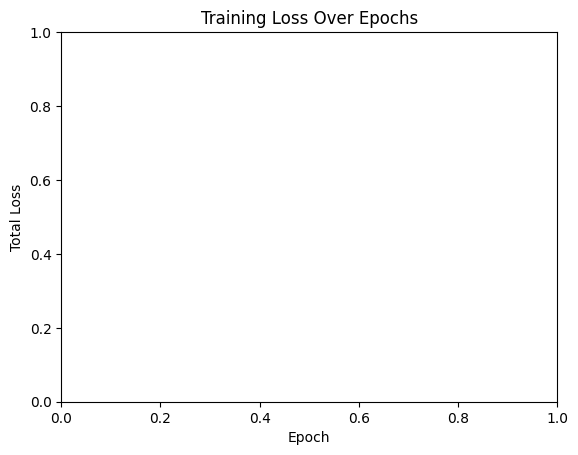

In [155]:
#다중 출력 모델
epoch_list = []
loss_list = []

train_loss_list = []
train_accuracy_list = []

validation_loss_list = []
validation_accuracy_list = []

plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Over Epochs')
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0.0
    total_corrects = [0] * len(labels)
    for images, *labels in train_data_loader:  # Use *labels to unpack the list of label tensors
        images = images.to(device)
        labels = [label.to(device) for label in labels]  # Move each label tensor to the device
        # Forward pass
        outputs = model(images)

        integer_labels = [torch.argmax(label, dim=1) for label in labels]
        
        # Calculate loss for each output
        losses = [criterion(output, label) for output, label in zip(outputs, integer_labels)]
        
        # Sum the losses
        total_loss = sum(losses)
        '''

        loss_list.append(total_loss.item()/(len(loss_list)+1))
        if len(epoch_list) == 0:
            epoch_list.append(1/len(train_data_loader))
        else:
            epoch_list.append(epoch_list[-1] + 1/len(train_data_loader))
            
        plt.figure(figsize=(15, 5))
        plt.plot(epoch_list,loss_list, label='Training Loss', color='blue')
        plt.legend(loc='upper right')
        plt.xticks([i for i in range(num_epochs+1)])
        plt.yticks([i for i in range(3)])
        plt.ylim(0,3)
        plt.show()
        clear_output(wait=True)
        '''

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        corrects = [torch.sum(torch.argmax(output, 1) == torch.argmax(label, 1)).item() for output, label in zip(outputs, labels)]
        total_corrects = [total + correct for total, correct in zip(total_corrects, corrects)]

    avg_train_loss = total_loss / len(train_data_loader.dataset)
    train_accuracies = [total_correct / len(train_data_loader.dataset) for total_correct in total_corrects]

    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracies)
    
    # Validation
    model.eval()
    total_corrects = [0] * len(labels)
    total_loss = 0.0

    with torch.no_grad():
        for images, *labels in validation_data_loader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]

            # Forward pass
            outputs = model(images)

            integer_labels = [torch.argmax(label, dim=1) for label in labels]

            # Calculate loss for each output
            losses = [criterion(output, label) for output, label in zip(outputs, integer_labels)]

            # Sum the losses
            total_loss += sum(losses).item()

            # Calculate total correct predictions for each output
            corrects = [torch.sum(torch.argmax(output, 1) == torch.argmax(label, 1)).item() for output, label in zip(outputs, labels)]
            total_corrects = [total + correct for total, correct in zip(total_corrects, corrects)]

    # Calculate average loss and accuracy for each output
    avg_validation_loss = total_loss / len(validation_data_loader.dataset)
    validation_accuracies = [total_correct / len(validation_data_loader.dataset) for total_correct in total_corrects]

    validation_loss_list.append(avg_validation_loss)
    validation_accuracy_list.append(validation_accuracies)

    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}")
    print("Training Accuracy : ")
    for i, accuracy in enumerate(train_accuracies):
        print(f"Accuracy{i + 1}: {accuracy * 100:.2f}%, ", end="")
    print()
    print("Validation Accuracy : ")
    for i, accuracy in enumerate(validation_accuracies):
        print(f"Accuracy{i + 1}: {accuracy * 100:.2f}%, ", end="")
    print()

In [156]:
torch.save(model.state_dict(), 'multi_output_.pth')

In [ ]:
# 저장한 모델 불러오기

label_classes = []
data_ex = next(iter(validation_dataset))
for i in range(1,len(data_ex)):
    labelSize = data_ex[i].size()
    label_classes.append(labelSize.numel())
print(label_classes)

model = MultiOutputModel(label_classes)

loaded_model.load_state_dict(torch.load('multi_output_model.pth'))